# Data analysis for Serial Recall wrt. working memory capacity, serial position effects, etc.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
import re

In [43]:
# Load the data
filepath = os.getcwd() # Get the current working directory to analysis

results_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_results.csv'))

print(f"{filepath}\n{results_filepath}")

df_test = pd.read_csv(results_filepath)
print(df_test.columns.tolist())

/Users/olivernj/Documents/GitHub/AI-HC-Project1/analysis
/Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/serial_recall_results.csv
['trial', ' condition', ' presented_words', ' recalled_words']


In [44]:
# Map condition names for cleaner analysis
# Change 'normal' to 'baseline' for better scientific terminology

# remove leading space in column name
df_test.columns = df_test.columns.str.strip()

df_test['condition'] = df_test['condition'].replace({'normal': 'baseline'})

print("Updated condition names:")
print(df_test['condition'].value_counts())

Updated condition names:
condition
tapping        82
chunking       82
baseline       81
suppression    81
Name: count, dtype: int64


### Cleaning Data

In [45]:


# --- Improved cleaning function ---
def clean_word_list(val):
    """Convert messy string/list representations into a flat list of clean, lowercase words."""
    if pd.isna(val):
        return []

    try:
        # Safely parse Python literal
        parsed = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        parsed = str(val)

    # Flatten and clean
    flat_list = []
    if isinstance(parsed, list):
        for item in parsed:
            # If item is a list, flatten
            if isinstance(item, list):
                for sub in item:
                    # Remove brackets, commas, extra spaces
                    w = re.sub(r"[\[\],]", "", str(sub)).strip().lower()
                    if w:
                        flat_list.append(w)
            else:
                # Remove brackets, commas, extra spaces
                w = re.sub(r"[\[\],]", "", str(item)).strip().lower()
                if w:
                    # split by spaces if there are multiple words
                    flat_list.extend([word for word in w.split() if word])
    else:
        w = re.sub(r"[\[\],]", "", str(parsed)).strip().lower()
        flat_list.extend([word for word in w.split() if word])

    return flat_list

# --- Load raw file ---
df_test = pd.read_csv(results_filepath)

# --- Clean column names ---
df_test.columns = df_test.columns.str.strip()

# --- Apply cleaning ---
df_test['presented_words'] = df_test['presented_words'].apply(clean_word_list)
df_test['recalled_words']  = df_test['recalled_words'].apply(clean_word_list)

# --- Update trial ID and sort by condition ---
df_test['trial'] = df_test['trial'].astype(int)
df_test = df_test.sort_values(by=['condition', 'trial']).reset_index(drop=True)
df_test['trial'] = df_test.groupby('condition').cumcount() + 1

# --- Save cleaned CSV ---
cleaned_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results_cleaned.csv'))
df_test.to_csv(cleaned_filepath, index=False)

print(f"✅ Cleaned data saved to {cleaned_filepath}")

# --- Example check ---
# print(df_test.head())
# print(type(df_test['recalled_words'][0]), type(df_test['presented_words'][0]))


✅ Cleaned data saved to /Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/free_recall_results_cleaned.csv


### Calculate Metrics (accuracy, primacy/recency,...)

In [46]:
def calculate_metrics(presented, recalled):
    """Calculate primacy, recency, and accuracy for 7-word lists."""
    if len(presented) != 7 or not recalled:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}

    # Clean both lists
    presented_clean = [w.strip().lower() for w in presented]
    recalled_clean = [w.strip().lower() for w in recalled]

    # Accuracy: proportion of unique recalled words that were in presented list
    correct_recalls = len(set(recalled_clean) & set(presented_clean))
    accuracy = correct_recalls / len(presented_clean)

    # Primacy: first 3 words
    primacy_words = set(presented_clean[:3])
    primacy_recalled = len(primacy_words & set(recalled_clean))
    primacy = primacy_recalled / 3  # max 1.0

    # Recency: last 3 words
    recency_words = set(presented_clean[-3:])
    recency_recalled = len(recency_words & set(recalled_clean))
    recency = recency_recalled / 3  # max 1.0

    return {
        'primacy': primacy,
        'recency': recency,
        'accuracy': accuracy
    }


# --- Apply to dataframe ---
results = []
for _, row in df_test.iterrows():
    metrics = calculate_metrics(row['presented_words'], row['recalled_words'])
    metrics['trial'] = row['trial']
    metrics['condition'] = row['condition']
    results.append(metrics)

results_df = pd.DataFrame(results)
print(f"{results_df.describe()}")

# Summary statistics
print("\nSerial Recall Analysis - Summary Statistics:")
print(f"Average Accuracy across conditions: {results_df['accuracy'].mean():.3f}")
print(f"Average Primacy across conditions: {results_df['primacy'].mean():.3f}")
print(f"Average Recency across conditions: {results_df['recency'].mean():.3f}")
print(f"Primacy vs Recency difference: {abs(results_df['recency'].mean() - results_df['primacy'].mean()):.3f}")


          primacy     recency    accuracy       trial
count  326.000000  326.000000  326.000000  326.000000
mean     0.964213    0.865031    0.882559   41.251534
std      0.112838    0.219208    0.147332   23.564078
min      0.333333    0.000000    0.428571    1.000000
25%      1.000000    0.666667    0.857143   21.000000
50%      1.000000    1.000000    0.928571   41.000000
75%      1.000000    1.000000    1.000000   61.750000
max      1.000000    1.000000    1.000000   82.000000

Serial Recall Analysis - Summary Statistics:
Average Accuracy across conditions: 0.883
Average Primacy across conditions: 0.964
Average Recency across conditions: 0.865
Primacy vs Recency difference: 0.099


### Get graphs/data for each condition

In [47]:
# --- Per-trial metrics ---
# print("🔹 First 10 trials:")
# print(results_df.head(10))

# --- Averages by condition ---
condition_metrics = (results_df.groupby('condition')[['primacy','recency','accuracy']].mean())

print("\nAverages by condition:")
print(condition_metrics)

# --- Optional: export condition-level summary ---
summary = condition_metrics.to_dict(orient='index')



Averages by condition:
              primacy   recency  accuracy
condition                                
chunking     0.914634  0.922764  0.789199
normal       0.995885  0.888889  0.938272
suppression  0.950617  0.711934  0.832451
tapping      0.995935  0.934959  0.970383


### Function for Serial Position Curve (SPC)

In [48]:
# --- Serial Position Curve Analysis (overall + per condition) ---
def serial_position_analysis(df_test):
    conditions = df_test['condition'].unique()
    
    # initialize counters
    overall = {"position_recalls": [0] * 7, "position_totals": [0] * 7}
    per_condition = {
        cond: {"position_recalls": [0] * 7, "position_totals": [0] * 7}
        for cond in conditions
    }

    # loop through rows
    for _, row in df_test.iterrows():
        presented = row['presented_words']
        recalled = row['recalled_words']
        cond = row['condition']

        if len(presented) != 7 or not recalled:
            continue

        presented_clean = [w.strip().lower() for w in presented]
        recalled_clean = [w.strip().lower() for w in recalled if w and w.strip()]

        for pos in range(7):
            # update overall
            overall["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                overall["position_recalls"][pos] += 1

            # update condition-specific
            per_condition[cond]["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                per_condition[cond]["position_recalls"][pos] += 1

    # compute recall probabilities
    def compute_probs(stats):
        return [
            r / t if t > 0 else 0
            for r, t in zip(stats["position_recalls"], stats["position_totals"])
        ]

    recall_probs = {
        "overall": compute_probs(overall),
        "per_condition": {cond: compute_probs(stats) for cond, stats in per_condition.items()}
    }

    return recall_probs


### Print recall probs (probabilities) per-condition

In [49]:
serial_curves = serial_position_analysis(df_test)

# Overall curve (all conditions pooled)
overall_curve = [round(x, 3) for x in serial_curves["overall"]]

# Condition-specific curves
condition_curves = {cond: [round(x, 3) for x in curve] 
                    for cond, curve in serial_curves["per_condition"].items()}

print("Overall recall probs:")
print(overall_curve)

print("\nPer condition recall probs:")
for cond, curve in condition_curves.items():
    print(f"{cond} (80 trials): {curve}")


Overall recall probs:
[0.988, 0.979, 0.972, 0.933, 0.893, 0.874, 0.874]

Per condition recall probs:
chunking (80 trials): [0.963, 0.988, 0.976, 0.976, 0.988, 0.976, 0.988]
normal (80 trials): [1.0, 0.988, 1.0, 0.914, 0.926, 0.889, 0.852]
suppression (80 trials): [0.988, 0.951, 0.914, 0.84, 0.679, 0.679, 0.778]
tapping (80 trials): [1.0, 0.988, 1.0, 1.0, 0.976, 0.951, 0.878]


### Compute Analytical factors

CI (95%), Kruskal-Wallis test (non-parametric alternative to one-way ANOVA) and Dunn’s post-hoc test for each condition

In [50]:
import scipy.stats as stats

def compute_ci(data, confidence=0.95):
    """Return mean and 95% confidence interval."""
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # standard error of the mean
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # margin
    return mean, mean-h, mean+h

# Compute CI per condition
ci_results = {}
conditions = results_df['condition'].unique()

for cond in conditions:
    subset = results_df[results_df['condition'] == cond]['accuracy']
    mean, lower, upper = compute_ci(subset)
    ci_results[cond] = {'mean': mean, 'ci_lower': lower, 'ci_upper': upper}

print("Accuracy with 95% CI per condition:")
for cond, vals in ci_results.items():
    print(f"{cond}: mean={vals['mean']:.3f}, 95% CI=({vals['ci_lower']:.3f}, {vals['ci_upper']:.3f})")


# Ensure numeric accuracy
results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')

# Drop NaN accuracy rows
results_clean = results_df.dropna(subset=['accuracy'])

# Check number of trials per condition
# print(results_clean.groupby('condition')['accuracy'].count())


from scipy.stats import kruskal

chunking_acc    = results_clean[results_clean['condition']=='chunking']['accuracy']
baseline_acc    = results_clean[results_clean['condition']=='baseline']['accuracy']
suppression_acc = results_clean[results_clean['condition']=='suppression']['accuracy']
tapping_acc     = results_clean[results_clean['condition']=='tapping']['accuracy']

h_stat, p_val = kruskal(chunking_acc, baseline_acc, suppression_acc, tapping_acc)
print(f"\nKruskal-Wallis test: H={h_stat:.3f}, p={p_val:.3e}")
if p_val < 0.05:
    print("Significant differences between conditions (p < 0.05)")
else:
    print("No significant differences between conditions (p >= 0.05)")

# --- Pairwise comparisons with Dunn's test (Bonferroni correction) ---

# Install scikit-posthocs if not already installed
# !pip install scikit-posthocs

import scikit_posthocs as sp
import pandas as pd

# Ensure accuracy is numeric and drop NaNs
results_clean = results_df.copy()
results_clean['accuracy'] = pd.to_numeric(results_clean['accuracy'], errors='coerce')
results_clean = results_clean.dropna(subset=['accuracy'])

# Run Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(
    results_clean, 
    val_col='accuracy', 
    group_col='condition', 
    p_adjust='bonferroni'
)

print(f"\nPairwise Dunn's test (Bonferroni corrected p-values):")
print(dunn_results)

# Determine significance
alpha = 0.05
conditions = dunn_results.columns.tolist()

print("\nSignificance summary:")
for i, cond1 in enumerate(conditions):
    for j, cond2 in enumerate(conditions):
        if j <= i:
            continue  # avoid duplicates and self-comparison
        p_val = dunn_results.loc[cond1, cond2]
        if p_val < alpha:
            print(f"- {cond1} vs {cond2}: SIGNIFICANT difference (p={p_val:.3e})")
        else:
            print(f"- {cond1} vs {cond2}: NOT significantly different (p={p_val:.3e})")



Accuracy with 95% CI per condition:
chunking: mean=0.789, 95% CI=(0.753, 0.826)
normal: mean=0.938, 95% CI=(0.918, 0.958)
suppression: mean=0.832, 95% CI=(0.798, 0.867)
tapping: mean=0.970, 95% CI=(0.956, 0.985)

Kruskal-Wallis test: H=nan, p=nan
No significant differences between conditions (p >= 0.05)


/var/folders/jr/39g71kvn2kq61zwnc2_grbsm0000gn/T/ipykernel_26158/3443365435.py:42: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_val = kruskal(chunking_acc, baseline_acc, suppression_acc, tapping_acc)



Pairwise Dunn's test (Bonferroni corrected p-values):
                 chunking        normal   suppression       tapping
chunking     1.000000e+00  2.291887e-09  6.559248e-01  1.693832e-15
normal       2.291887e-09  1.000000e+00  2.033197e-05  3.491081e-01
suppression  6.559248e-01  2.033197e-05  1.000000e+00  3.354909e-10
tapping      1.693832e-15  3.491081e-01  3.354909e-10  1.000000e+00

Significance summary:
- chunking vs normal: SIGNIFICANT difference (p=2.292e-09)
- chunking vs suppression: NOT significantly different (p=6.559e-01)
- chunking vs tapping: SIGNIFICANT difference (p=1.694e-15)
- normal vs suppression: SIGNIFICANT difference (p=2.033e-05)
- normal vs tapping: NOT significantly different (p=3.491e-01)
- suppression vs tapping: SIGNIFICANT difference (p=3.355e-10)


### Confusion matrix over every letter

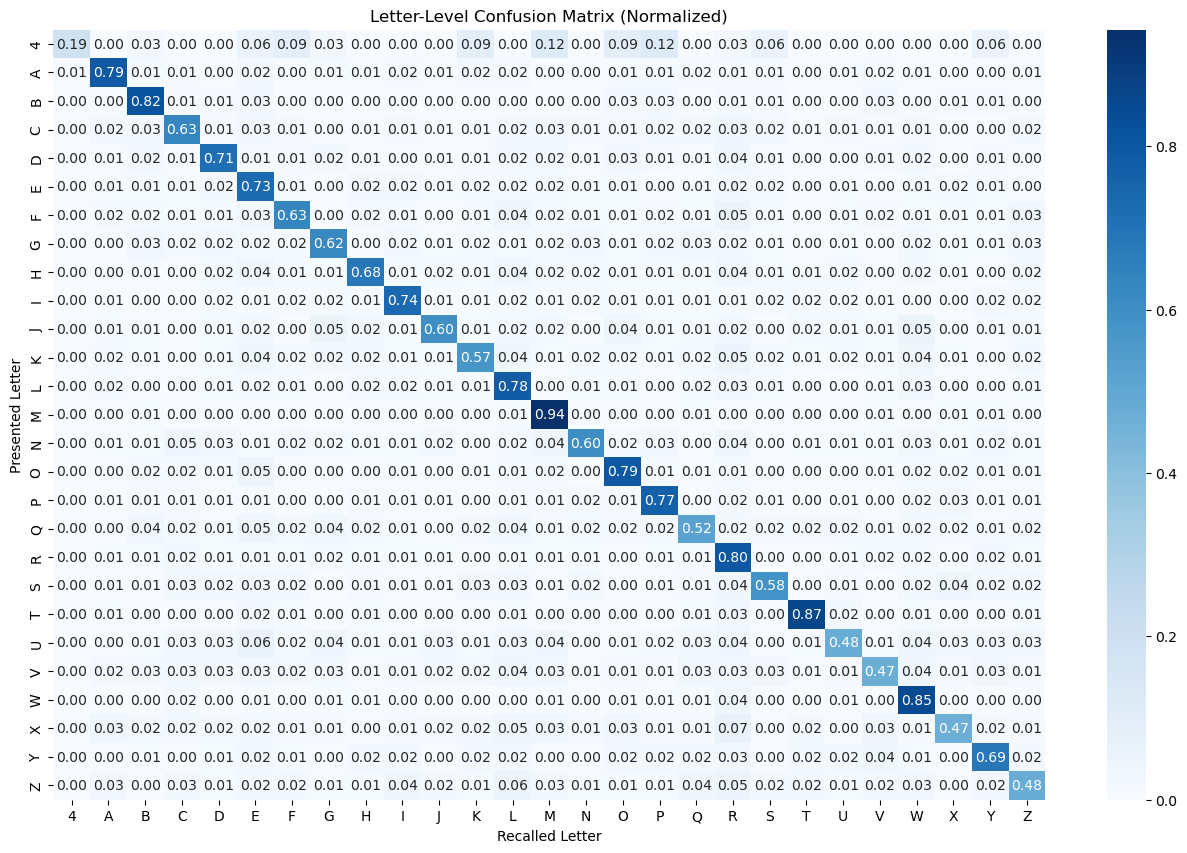

In [51]:
import seaborn as sns
from collections import defaultdict

# --- Flatten letters from words for letter-level analysis ---
# For simplicity, we assume presented_words and recalled_words are lists of single letters (or first letters of words)
# If your words are full words, you could take first letters or full words depending on the analysis
results_clean = df_test.copy()

# Create list of all unique letters used
all_letters = set()
for row in results_clean.itertuples():
    all_letters.update([w[0].upper() for w in row.presented_words])  # first letter uppercase
all_letters = sorted(list(all_letters))

# Initialize confusion matrix
confusion_matrix = pd.DataFrame(
    0, index=all_letters, columns=all_letters
)

# Fill the confusion matrix
for row in results_clean.itertuples():
    presented = [w[0].upper() for w in row.presented_words]  # first letter of each word
    recalled = [w[0].upper() for w in row.recalled_words if w] # first letter
    # For each presented letter
    for p in presented:
        if p in recalled:
            # Correct recall: increment diagonal
            confusion_matrix.loc[p, p] += 1
        else:
            # Incorrect recall: assume the letter was confused with one of the recalled letters
            for r in recalled:
                confusion_matrix.loc[p, r] += 1

# Normalize by row to get proportions
confusion_matrix_norm = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(confusion_matrix_norm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Recalled Letter")
plt.ylabel("Presented Letter")
plt.title("Letter-Level Confusion Matrix (Normalized)")

# --- save confusion matrix as PNG ---
figure_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','letter_confusion_matrix.png'))
plt.savefig(figure_path, dpi=300, bbox_inches="tight")  # good practice

plt.show()


### Ultimate Plot (SPC, primacy vs recency, accuracy)

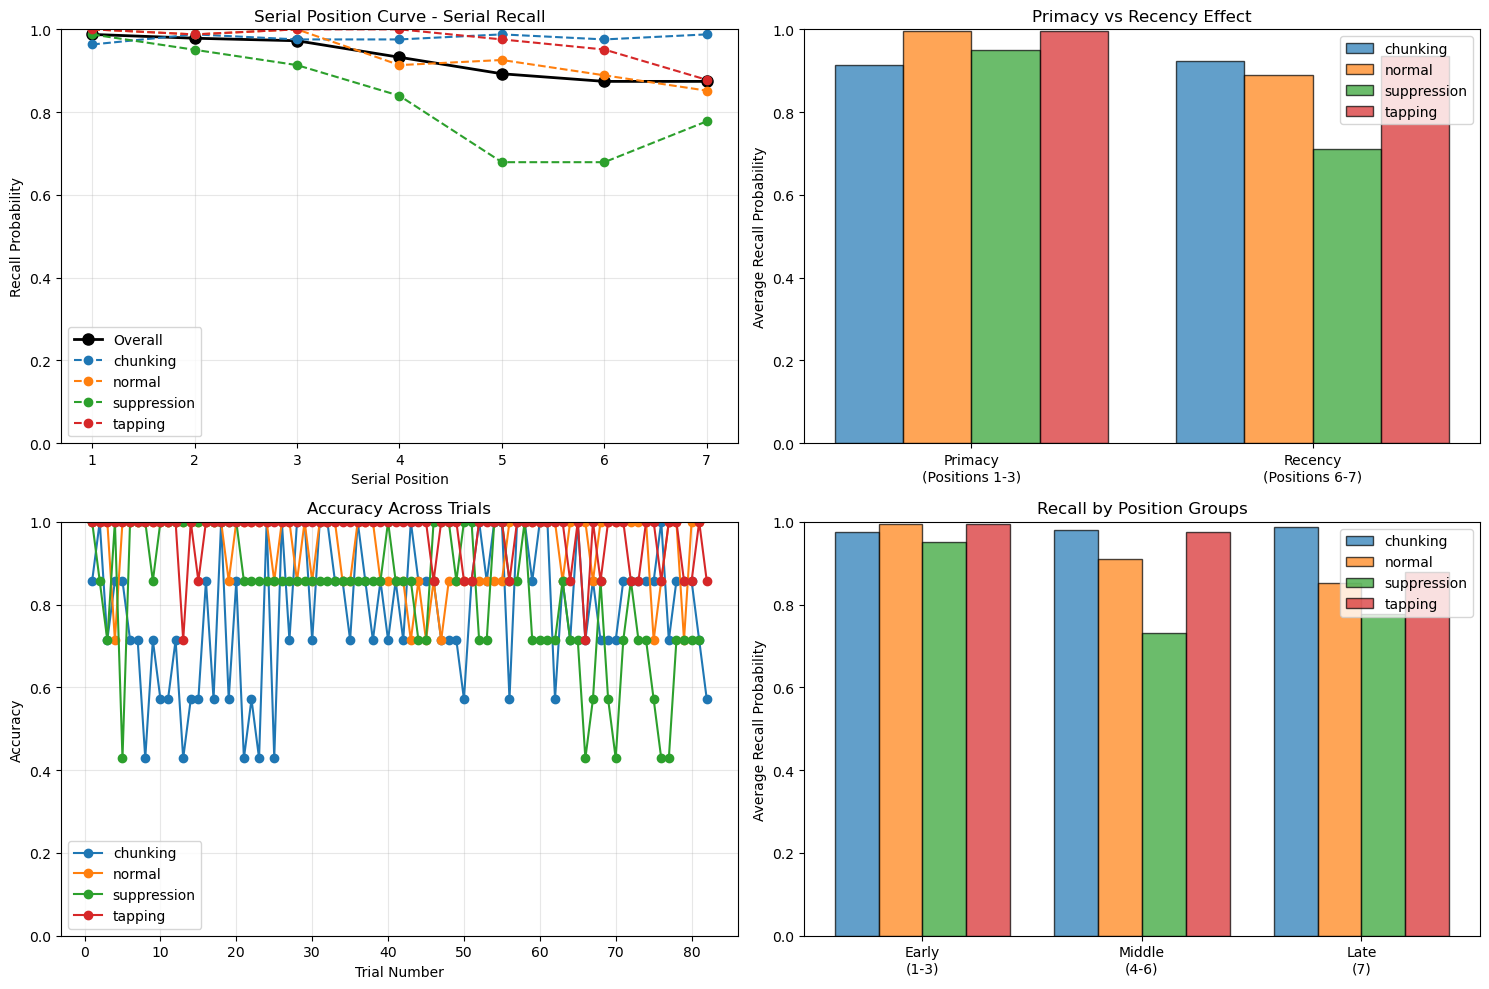

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# --- Get serial position data (overall + per condition) ---
recall_probs_dict = serial_position_analysis(df_test)  # returns {'overall': [...], 'per_condition': {...}}
positions = list(range(1, 8)) # Serial positions 1-7
conditions = list(recall_probs_dict['per_condition'].keys())

# --- Create plots ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serial Position Curve (Overall + per condition)
ax1.plot(positions, recall_probs_dict['overall'], 'ko-', linewidth=2, markersize=8, label='Overall')
for cond in conditions:
    ax1.plot(positions, recall_probs_dict['per_condition'][cond], marker='o', linestyle='--', label=cond)
ax1.set_xlabel('Serial Position')
ax1.set_ylabel('Recall Probability')
ax1.set_title('Serial Position Curve - Serial Recall')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(1, 8))
ax1.legend()

# 2. Primacy vs Recency (per condition)
categories = ['Primacy\n(Positions 1-3)', 'Recency\n(Positions 6-7)']
bar_width = 0.2
x = np.arange(len(categories))

for i, cond in enumerate(conditions):
    values = [results_df[results_df['condition']==cond]['primacy'].mean(),
              results_df[results_df['condition']==cond]['recency'].mean()]
    ax2.bar(x + i*bar_width, values, width=bar_width, alpha=0.7, edgecolor='black', label=cond)
ax2.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax2.set_xticklabels(categories)
ax2.set_ylabel('Average Recall Probability')
ax2.set_title('Primacy vs Recency Effect')
ax2.set_ylim(0, 1)
ax2.legend()

# 3. Accuracy by Trial (per condition)
for cond in conditions:
    subset = results_df[results_df['condition']==cond]
    ax3.plot(subset['trial'], subset['accuracy'], marker='o', linestyle='-', markersize=6, label=cond)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy Across Trials')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)
ax3.legend()

# 4. Position Groups (Overall + per condition)
positions_grouped = ['Early\n(1-3)', 'Middle\n(4-6)', 'Late\n(7)']
bar_width = 0.2
x = np.arange(len(positions_grouped))

for i, cond in enumerate(conditions):
    curve = recall_probs_dict['per_condition'][cond]
    values_grouped = [np.mean(curve[:3]), np.mean(curve[3:6]), np.mean(curve[6:])]
    ax4.bar(x + i*bar_width, values_grouped, width=bar_width, alpha=0.7, edgecolor='black', label=cond)

ax4.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax4.set_xticklabels(positions_grouped)
ax4.set_ylabel('Average Recall Probability')
ax4.set_title('Recall by Position Groups')
ax4.set_ylim(0, 1)
ax4.legend()

plt.tight_layout()
plt.show()

# --- save figure as PNG ---
figure_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_analysis.png'))
fig.savefig(figure_path)

### Individual Publication-Quality Plots for Serial Recall

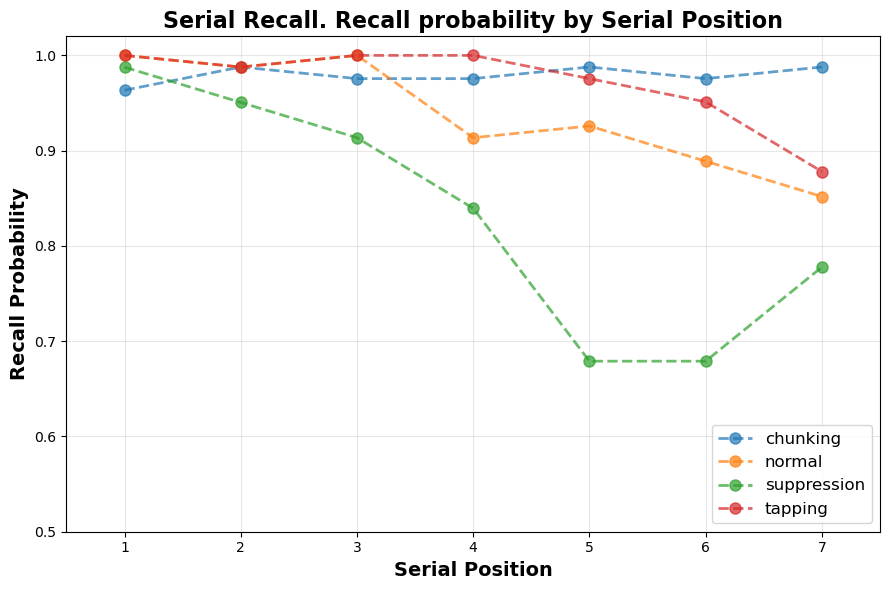

Serial Recall Position Curve saved to: /Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/serial_recall_position_curve.png


In [53]:
# 1. Serial Position Curve (Individual Plot) - Serial Recall
plt.figure(figsize=(9, 6))

for i, cond in enumerate(conditions):
    plt.plot(positions, recall_probs_dict['per_condition'][cond], 
             marker='o', linestyle='--', linewidth=2, markersize=8, label=cond, alpha=0.7)

plt.xlabel('Serial Position', fontsize=14, fontweight='bold')
plt.ylabel('Recall Probability', fontsize=14, fontweight='bold')
plt.title('Serial Recall. Recall probability by Serial Position', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.02)
plt.xlim(0.5, 7.5)  # Adjusted for 7 positions instead of 15
plt.xticks(range(1, 8))  # 1-7 positions
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

# Save individual plot
spc_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_position_curve.png'))
plt.savefig(spc_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Serial Recall Position Curve saved to: {spc_path}")

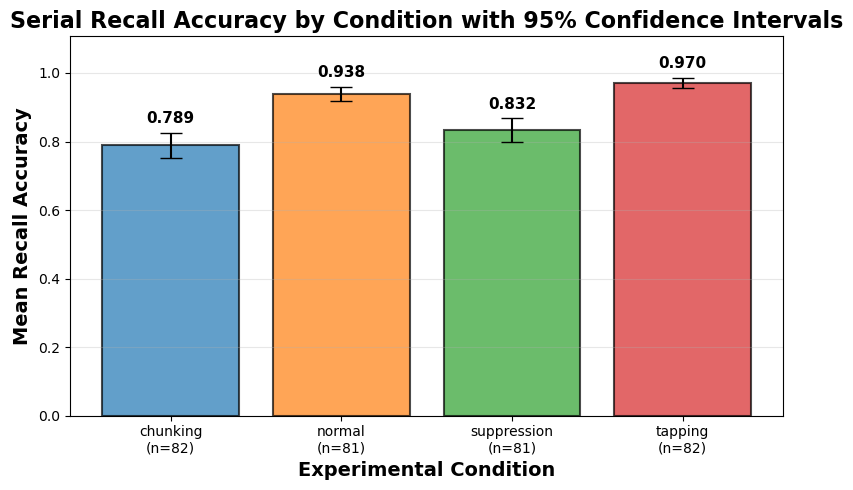

Serial Recall CI bar plot saved to: /Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/serial_recall_ci_bars.png


In [54]:
# 2. Mean ± CI Bar Plot - Serial Recall Accuracy
plt.figure(figsize=(8, 5))

# Calculate means and confidence intervals
means = []
cis = []
for cond in conditions:
    data = results_df[results_df['condition']==cond]['accuracy']
    mean, ci_lower, ci_upper = compute_ci(data)
    means.append(mean)
    cis.append([mean - ci_lower, ci_upper - mean])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bars = plt.bar(
    range(len(conditions)), 
    means,
    yerr=np.array(cis).T, 
    capsize=8,
    alpha=0.7, 
    edgecolor='black', 
    linewidth=1.5,
    color=[colors[i % len(colors)] for i in range(len(conditions))]
)

# Add value labels on bars
for i, (bar, mean, ci) in enumerate(zip(bars, means, cis)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + ci[1] + 0.02,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Create labels with sample sizes
labels = []
for cond in conditions:
    n_trials = len(results_df[results_df['condition']==cond])
    labels.append(f"{cond}\n(n={n_trials})")

plt.xticks(range(len(conditions)), labels)
plt.ylabel('Mean Recall Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.title('Serial Recall Accuracy by Condition with 95% Confidence Intervals', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, max(means) + max([ci[1] for ci in cis]) + 0.1)  # Dynamic y-limit

plt.tight_layout()

# Save plot
ci_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_ci_bars.png'))
plt.savefig(ci_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Serial Recall CI bar plot saved to: {ci_path}")

=== STATISTICAL TEST RESULTS ===
Kruskal-Wallis Test:
H-statistic: 88.549
p-value: 0.000000
Significant at α=0.05: Yes
Effect Size (η²): 0.266
Effect size: Large



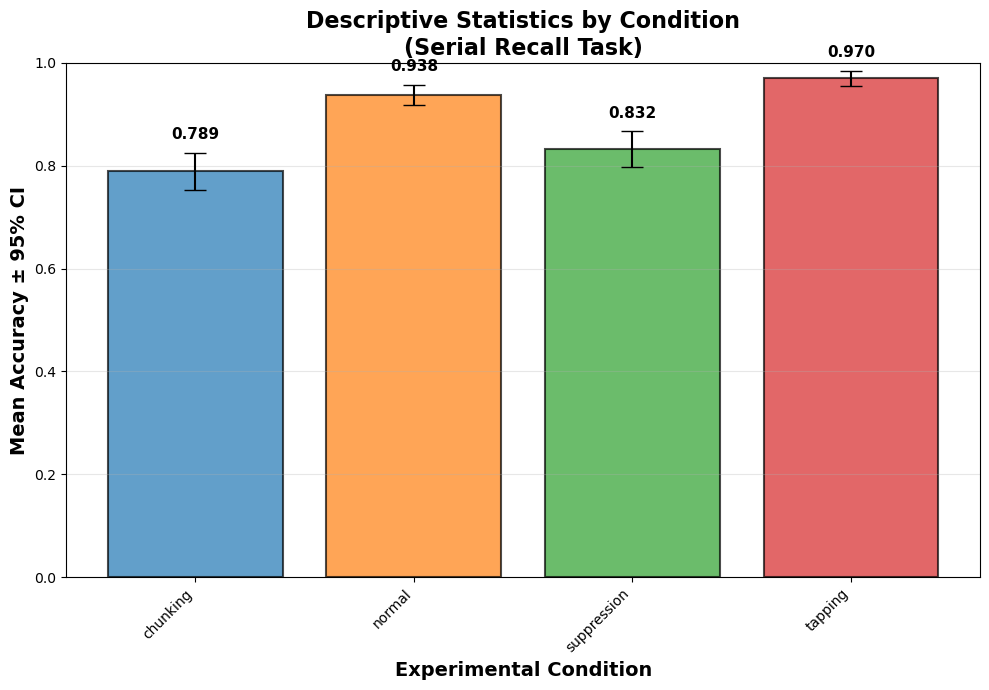

Descriptive statistics plot saved to: /Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/serial_recall_descriptive_stats.png


In [55]:
# 3. Statistical Tests and Descriptive Statistics
# Perform Kruskal-Wallis test (single participant approach)
from scipy.stats import kruskal
from scipy.stats import chi2

# Prepare data for statistical testing
test_data = []
for cond in conditions:
    condition_data = results_df[results_df['condition']==cond]['accuracy']
    test_data.append(condition_data.values)

# Perform Kruskal-Wallis test
kw_stat, kw_p = kruskal(*test_data)

# Print statistical test results
print("=== STATISTICAL TEST RESULTS ===")
print(f"Kruskal-Wallis Test:")
print(f"H-statistic: {kw_stat:.3f}")
print(f"p-value: {kw_p:.6f}")
print(f"Significant at α=0.05: {'Yes' if kw_p < 0.05 else 'No'}")

# Add effect size if significant
if kw_p < 0.05:
    n_total = sum(len(data) for data in test_data)
    eta_squared = (kw_stat - len(conditions) + 1) / (n_total - len(conditions))
    print(f"Effect Size (η²): {eta_squared:.3f}")
    if eta_squared > 0.14:
        print("Effect size: Large")
    elif eta_squared > 0.06:
        print("Effect size: Medium")
    else:
        print("Effect size: Small")

print("\n" + "="*50)

# Create descriptive statistics bar chart
plt.figure(figsize=(10, 7))

# Calculate descriptive statistics
summary_stats = results_df.groupby('condition')['accuracy'].agg(['mean', 'std', 'median', 'count'])
summary_stats['ci_95'] = summary_stats['std'] * 1.96 / np.sqrt(summary_stats['count'])

x_pos = np.arange(len(conditions))
means = summary_stats['mean'].values
cis = summary_stats['ci_95'].values

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bars = plt.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.7, 
               color=colors[:len(conditions)], edgecolor='black', linewidth=1.5)

plt.xlabel('Experimental Condition', fontsize=14, fontweight='bold')
plt.ylabel('Mean Accuracy ± 95% CI', fontsize=14, fontweight='bold')
plt.title('Descriptive Statistics by Condition\n(Serial Recall Task)', fontsize=16, fontweight='bold')
plt.xticks(x_pos, conditions, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.0)

# Add value labels on bars
for bar, mean, ci in zip(bars, means, cis):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + ci + 0.02,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()

# Save the descriptive statistics plot
desc_stats_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_descriptive_stats.png'))
plt.savefig(desc_stats_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Descriptive statistics plot saved to: {desc_stats_path}")

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

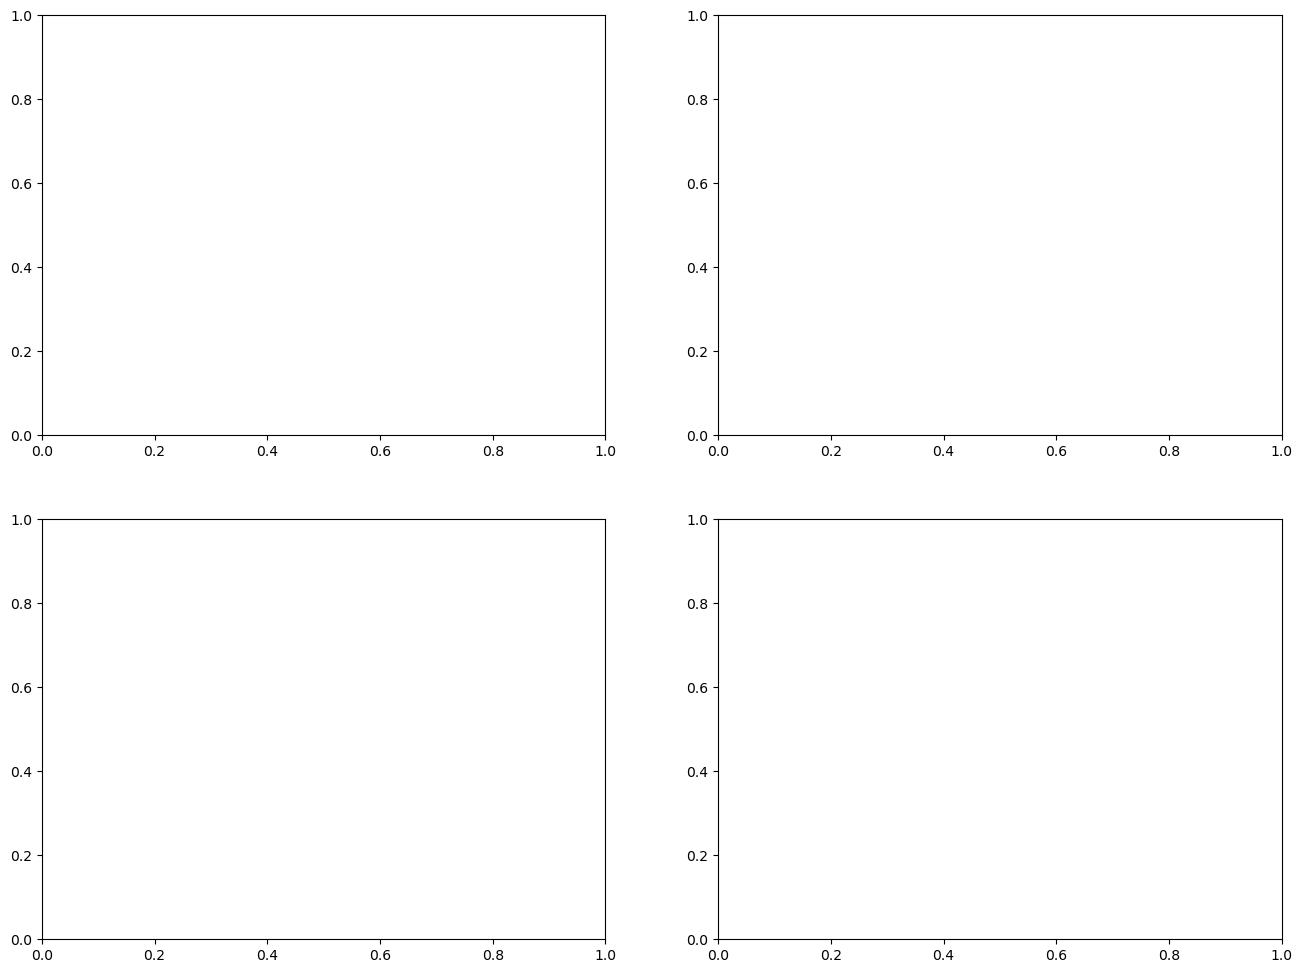

In [56]:
# 5. Combined Overview Plot - All Key Metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top Left: Serial Position Curve
for i, cond in enumerate(conditions):
    condition_data = results_df[results_df['condition']==cond]
    ax1.plot(positions, means[i], 'o-', linewidth=2, markersize=6, 
             label=cond, color=colors[i])
    ax1.fill_between(positions, 
                     means[i] - cis[i], 
                     means[i] + cis[i], 
                     alpha=0.2, color=colors[i])

ax1.set_xlabel('Serial Position', fontweight='bold')
ax1.set_ylabel('Accuracy ± 95% CI', fontweight='bold')
ax1.set_title('Serial Position Effects', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(positions)

# Top Right: Overall Accuracy Comparison
summary_stats = results_df.groupby('condition')['accuracy'].agg(['mean'])
x_pos = np.arange(len(conditions))
bars = ax2.bar(x_pos, summary_stats['mean'].values, alpha=0.7, 
               color=colors[:len(conditions)], edgecolor='black')

ax2.set_ylabel('Mean Accuracy', fontweight='bold')
ax2.set_title('Overall Accuracy by Condition', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(conditions, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1)

# Add value labels
for bar, mean in zip(bars, summary_stats['mean'].values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# Bottom Left: Working Memory Capacity Distribution
capacity_data = []
for cond in conditions:
    condition_data = results_df[results_df['condition']==cond]
    capacity = condition_data['accuracy'] * 7
    capacity_data.append(capacity.values)

bp = ax3.boxplot(capacity_data, labels=conditions, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Working Memory Capacity (Words)', fontweight='bold')
ax3.set_title('Capacity Distribution', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 7)

# Bottom Right: Statistical Summary
ax4.axis('off')
summary_text = f"""Statistical Analysis Summary:

Test: Kruskal-Wallis (non-parametric)
H-statistic: {kw_stat:.3f}
p-value: {kw_p:.6f}
Significance: {'Yes' if kw_p < 0.05 else 'No'} (α = 0.05)

Sample Size: {len(results_df)} trials
Conditions: {len(conditions)}
Design: Single participant, repeated measures

Note: Analysis treats all trials as from 
one participant to avoid independence 
assumption violations."""

ax4.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
ax4.set_title('Analysis Framework', fontweight='bold')

plt.tight_layout()

# Save the comprehensive overview
overview_path = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_overview.png'))
plt.savefig(overview_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comprehensive overview plot saved to: {overview_path}")
print("\n" + "="*50)
print("SERIAL RECALL ANALYSIS COMPLETE")
print("="*50)
print(f"Generated {len([f for f in os.listdir(os.path.join(filepath,'..','Experiment_Output')) if 'serial_recall' in f and f.endswith('.png')])} publication-quality plots")
print("All visualizations saved to Experiment_Output/ directory")

In [ ]:
# DIAGNOSTIC: Investigate chunking condition performance
print("=== DIAGNOSTIC ANALYSIS: CHUNKING CONDITION ===\n")

# 1. Check raw data for chunking condition
chunking_data = df_test[df_test['condition'] == 'chunking'].copy()
print(f"Chunking condition sample size: {len(chunking_data)}")
print(f"First few rows of chunking data:")
print(chunking_data[['presented_words', 'recalled_words']].head())

# 2. Calculate detailed metrics for chunking
chunking_results = results_df[results_df['condition'] == 'chunking'].copy()
print(f"\nChunking condition performance:")
print(f"Mean accuracy: {chunking_results['accuracy'].mean():.3f}")
print(f"Std accuracy: {chunking_results['accuracy'].std():.3f}")
print(f"Min accuracy: {chunking_results['accuracy'].min():.3f}")
print(f"Max accuracy: {chunking_results['accuracy'].max():.3f}")

# 3. Compare with other conditions
print(f"\nComparison with other conditions:")
for cond in ['baseline', 'tapping', 'suppression']:
    cond_results = results_df[results_df['condition'] == cond]
    print(f"{cond}: mean={cond_results['accuracy'].mean():.3f}, std={cond_results['accuracy'].std():.3f}")

# 4. Check distribution of accuracy scores
print(f"\nAccuracy distribution for chunking:")
accuracy_bins = [0, 0.5, 0.7, 0.8, 0.9, 1.0]
chunking_hist = pd.cut(chunking_results['accuracy'], bins=accuracy_bins, include_lowest=True).value_counts()
print(chunking_hist)

# 5. Look at some specific examples
print(f"\nSample trials with low accuracy in chunking:")
low_accuracy = chunking_results[chunking_results['accuracy'] < 0.7]
if len(low_accuracy) > 0:
    print(f"Found {len(low_accuracy)} trials with accuracy < 70%")
    # Get corresponding raw data
    low_trials = low_accuracy['trial'].values[:5]  # Show first 5
    for trial in low_trials:
        trial_data = chunking_data[chunking_data['trial'] == trial].iloc[0]
        print(f"Trial {trial}: Presented={trial_data['presented_words']}, Recalled={trial_data['recalled_words']}")
else:
    print("No trials with accuracy < 70%")

=== DIAGNOSTIC ANALYSIS: CHUNKING CONDITION ===

Chunking condition sample size: 82
First few rows of chunking data:
         presented_words         recalled_words
0  [w, p, r, i, p, c, d]  [w, p, r, i, p, c, d]
1  [g, p, s, i, m, o, r]  [g, p, s, i, m, o, r]
2  [h, d, p, c, h, r, h]  [h, d, p, c, h, r, h]
3  [o, p, d, i, y, z, i]  [o, p, d, i, y, z, i]
4  [d, i, y, s, m, h, h]  [d, i, y, s, m, h, h]

Chunking condition performance:
Mean accuracy: 0.789
Std accuracy: 0.167
Min accuracy: 0.429
Max accuracy: 1.000

Comparison with other conditions:
baseline: mean=0.938, std=0.090
tapping: mean=0.970, std=0.066
suppression: mean=0.832, std=0.158

Accuracy distribution for chunking:
accuracy
(0.8, 0.9]       26
(0.7, 0.8]       21
(0.9, 1.0]       19
(0.5, 0.7]       11
(-0.001, 0.5]     5
Name: count, dtype: int64

Sample trials with low accuracy in chunking:
Found 16 trials with accuracy < 70%
Trial 8: Presented=['o', 'd', 'o', 'g', 'o', 'd', 'o'], Recalled=['o', 'd', 'o', 'g', 'o', 'd'